## Continuous variable gradient-descent quantum process tomography

In this notebook, we demonstrate how the gradient descent quantum process
tomography task can tackle continuous variable quantum process with a larger
Hilbert space cutoff that previous works on the QPT of CV processes [2]. We
consider a cutoff of 32. Note however that for such a cutoff, we also need to
adjust the complex displacements that we apply as well as measure to collect
the data. For a very large cutoff, if we do not send probe states at larger
complex displacements, or measure Wigner functions at large values of the phase
space, we do not have any information about the higher Fock numbers and corresponding
elements of the Fock space.

The probes are coherent states $|\alpha_i\rangle$ that go
through a quantum process --- the Selective Number Dependent Arbitrary Phase
(SNAP) gate. The measurements are given by the parity (Wigner) function at
points $\beta_i$ given by $\Pi(\beta_i) = \sum_n (-1)^n D(\beta_i)|n\rangle\langle n| D^{\dagger}(\beta_i)$

We need to select a grid for the probes and measurement, and in this example we
consider a $10 \times 10$ grid for both.

We also need to select various hyperparameters such as the batch size for training
the learning rate etc. Results of the reconstruction might be sensitive to these
hyperparameters.


## References

[1] Shahnawaz Ahmed, Fernando Quijandría, Anton Frisk Kockum, "Gradient-descent
quantum process tomography by learning Kraus operators," (2022), [arXiv:2208.00812](https://arxiv.org/abs/2208.00812).

[2] Anis, Aamir, and A. I. Lvovsky. "Maximum-likelihood coherent-state quantum process tomography." New Journal of Physics 14.10 (2012): 105021.

[3] Fösel, Thomas, et al. "Efficient cavity control with SNAP gates." arXiv preprint arXiv:2004.14256 (2020).

In [1]:
import sys
import os

from functools import partial


import numpy as np


import scipy as sp
from scipy import stats
from scipy.special import binom


from qutip import Qobj, fidelity, ket2dm, qeye, wigner, coherent_dm
from qutip.superop_reps import kraus_to_choi
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qutip.visualization import hinton


from tqdm.auto import tqdm
from tqdm import trange


import jax
from jax import numpy as jnp
from jax import jit, vmap, grad
from jax.config import config


import cvxpy as cp


from matplotlib import pyplot as plt
import matplotlib.colors as colors

from gd_qpt.core import Displace, dag, expect, plot_choi
from gd_qpt.gd import predict, get_block, get_unblock, stiefel_update


config.update("jax_enable_x64", True)

### Generate the process from a SNAP gate

In [2]:
# Hilbert space dimension
N = 32

num_kraus = 3
snap_disp = 1.

thetas = jnp.array([np.pi, np.pi, -np.pi, -np.pi, np.pi, np.pi])/2
thetas = jnp.concatenate([thetas, jnp.zeros(N - len(thetas))])

op = Displace(N)(snap_disp)@jnp.diag(jnp.exp(1j*thetas)).reshape((1, N, N))@Displace(N)(-snap_disp)

### Convert to the Choi matrix and visualize the Choi matrix

In [3]:
def choi(kraus_ops):
    """Takes the Kraus reprensentation of a channel and returns the Choi matrix.

    Args:
        kraus_ops (np.ndarray): The (k, N, N)-array representing k Kraus ops.

    Returns:
        np.array: A (N^2, N^2) array representing the Choi matrix.
    """
    r, N, N = kraus_ops.shape
    vectorized_kraus = kraus_ops.reshape(r, N ** 2)
    return np.einsum("ij, il -> jl", vectorized_kraus, vectorized_kraus.conj())



kraus_true = op

# Qutip does not recognized Jax arrays so we need to convert to numpy
choi_qutip_test = kraus_to_choi([Qobj(np.array(kop)) for kop in kraus_true])
choi_true = choi(kraus_true)# choi_qutip.full()
choi_qutip = Qobj(choi_true, dims=choi_qutip_test.dims, superrep="choi")

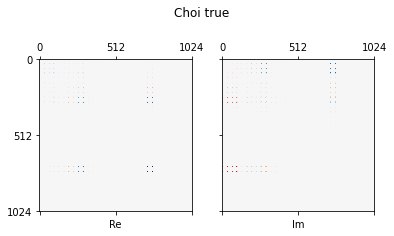

In [4]:
plot_choi(choi_true, title="Choi true")
plt.show()

### Probes, measurements and data for QPT

Let us generate some coherent states as probes, parity as measurements to
obtain simulated data with added Gaussian noise

In [5]:
alpha_max = 2.5
alpha_grid = 10

beta_max = 3
beta_grid = 10


xvec_alphas = jnp.linspace(-alpha_max, alpha_max, alpha_grid)
yvec_alphas = jnp.linspace(-alpha_max, alpha_max, alpha_grid)

X, Y = jnp.meshgrid(xvec_alphas, yvec_alphas)
alphas = (X + 1j*Y).ravel()

xvec_betas = jnp.linspace(-beta_max, beta_max, beta_grid)
yvec_betas = jnp.linspace(-beta_max, beta_max, beta_grid)

X, Y = jnp.meshgrid(xvec_betas, yvec_betas)

betas = (X + 1j*Y).ravel()

In [6]:
def apply_op(op, x=None):
    """
    Applies a Krauss operator to an input state x.
    """
    out = op@x@dag(op)
    return out


@jit
def apply_process(ops, v, tol=None):
    """
    Applies the process tensor to the vector of density matrices
    
    Args:
        ops (ndarray): An array of k Krauss operators of shape (k, N, N)
        v (ndarray): An array of m density matrices of shape (m, N, N)
        
        
    Returns:
        v_out (ndarray): The list (array) of m density matrices each transformed
                         after applying the process.
    """
    mapped = jit(vmap(vmap(apply_op, in_axes = [0, None]), in_axes=[None, 0]))
    return jnp.sum(mapped(ops, v), axis=1)


# Qutip does not take Jax arrays so we need to convert to numpy
probes = jnp.array([coherent_dm(N, np.array(alpha)).full() for alpha in alphas])
output_states = apply_process(kraus_true, probes)

### Measurements and data

Let us generate the Parity operators for measurements and compute the
expectation value of the operators 

In [7]:
def fock_dm(N, n=0):
    r"""Generates the dm representation of a Fock state.
    
    Args:
        N (int): Number of Fock states in the Hilbert space
        n (int): Number state (defaults to vacuum state, n = 0)

    Returns:
        :obj:`jnp.ndarray`: Number state :math:`|n\rangle`

    """
    zeros = jnp.zeros((N, N), dtype=jnp.complex128)  # column of zeros
    zeros = zeros.at[n, n].set(1.0)
    return zeros

parity_op = jnp.sum(jnp.array([((-1)**i)*fock_dm(N, i) for i in range(N)]), axis=0)
D = Displace(N)


@jit
def wigner_op(beta):
    """
    """
    displace = D(beta)
    A = displace@parity_op@dag(displace)
    mop = (A)*(2/jnp.pi)
    return mop


get_wigner_ops = jit(vmap(wigner_op))
measurements = get_wigner_ops(betas)

vectorized_expect = jit(vmap(vmap(expect, in_axes = [0, None]), in_axes = [None, 0]))
expvals = vectorized_expect(measurements, output_states)

data = expvals + np.random.uniform(0, .01, size=expvals.shape)

### Random initialization of Kraus operators and gradient-descent on the Stiefel manifold

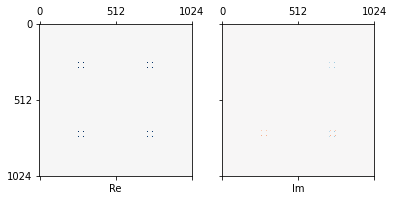

In [8]:
params_init = jnp.array([rand_unitary(N, density=0.01).full()/np.sqrt(num_kraus) for w in range(num_kraus)])
params = get_block(params_init)

np.testing.assert_array_almost_equal(get_unblock(params, num_kraus), params_init)

choi_initial_qutip = kraus_to_choi([Qobj(np.array(kop)) for kop in params_init])
choi_initial = choi_initial_qutip.full()

plot_choi(choi_initial)
plt.show()

### Let us plot a random Wigner functions of a probe, resulting state after process, coarse samples and noisy data

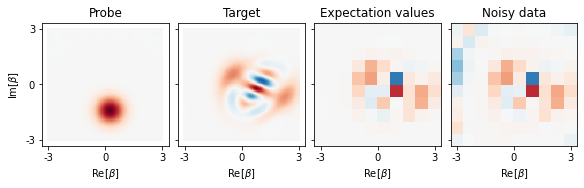

In [9]:
i = 25

fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(8, 2.5), constrained_layout=True)
norm = colors.TwoSlopeNorm(vmin=-2/np.pi, vcenter=0, vmax=2/np.pi)

probe_dm = Qobj(np.array(probes[i]))
true_dm = Qobj(np.array(output_states[i]))
pred_states = apply_process(params_init, probes)
predicted_dm = Qobj(np.array(pred_states[i]))

xvec = yvec = np.linspace(-beta_max, beta_max, 100)
w_probe = wigner(probe_dm, xvec, yvec, g=2)

# A finer grid to see the full Wigner data
w_full = wigner(true_dm, xvec, yvec, g=2)

# A coarse grid that we sample from
w_coarse = wigner(true_dm, xvec_betas, yvec_betas, g=2)

# Our data
w_data = data[i].reshape((xvec_betas.shape[0], yvec_betas.shape[0]))

im = ax[0].pcolor(xvec, yvec, w_probe,
                  cmap="RdBu_r", norm=norm)
im = ax[1].pcolor(xvec, yvec,
                  w_full, cmap="RdBu_r", norm=norm)
im = ax[2].pcolor(xvec_betas, yvec_betas,
                  w_coarse, cmap="RdBu_r", norm=norm)
im = ax[3].pcolor(xvec_betas, yvec_betas,
                  w_data, cmap="RdBu_r", norm=norm)


ax[0].set_ylabel(r"Im[$\beta$]")
ax[0].set_xlabel(r"Re[$\beta$]")
ax[1].set_xlabel(r"Re[$\beta$]")
ax[2].set_xlabel(r"Re[$\beta$]")
ax[3].set_xlabel(r"Re[$\beta$]")

ax[0].set_xticks([-beta_max, 0, beta_max])
ax[1].set_xticks([-beta_max, 0, beta_max])
ax[0].set_yticks([-beta_max, 0, beta_max])
ax[1].set_yticks([-beta_max, 0, beta_max])

ax[0].set_xticklabels([-beta_max, 0, beta_max])
ax[1].set_xticklabels([-beta_max, 0, beta_max])
ax[0].set_yticklabels([-beta_max, 0, beta_max])
ax[1].set_yticklabels([-beta_max, 0, beta_max])

ax[0].set_title("Probe")
ax[1].set_title("Target")
ax[2].set_title("Expectation values")
ax[3].set_title("Noisy data")

plt.show()

### Loss function

In [10]:
@jit
def loss(params, data, probes, measurements):
    """Loss function for the trainnig.

    Args:
        params (array[complex]): Kraus operators stacked one on top of the other
        data (array[complex]): An array of measured expectation values
        probes (array[complex]): The probes operators.
        measurements (array[complex]): The measurement operators.

    Returns:
        loss (float): A scalar loss
    """
    # note that we are assuming the num_kraus to be the same here
    # and it is a global variable
    # TODO: make it a partial static variable
    k_ops = get_unblock(params, num_kraus)
    out_dm = apply_process(k_ops, probes)
    data_pred = vectorized_expect(measurements, out_dm)

    l2 = jnp.sum(((data - data_pred)**2))
    return l2 + 0.001*jnp.linalg.norm(params, 1)

loss(params, expvals, probes, measurements)

DeviceArray(126.24644139, dtype=float64)

### Loss gradients using batches of probes and measurements

In [11]:
def generate_batch(batch_size, num_probes, num_measurements):
    """Generates random indices to select a batch of the data 
        (probes x measurements) assuming same number of probes and measurements

    Args:
        batch_size (int): Batch size
        len_indices (int): Length of training data 
                          (probes and measurements are assumed to be the same)

    Returns:
        idx : A meshgrid of indices for selecting the data.
        idx1, idx2 (array): Indices for the probes and measurements.
    """
    idx1 = np.random.randint(0, num_probes, size=[batch_size])
    idx2 = np.random.randint(0, num_measurements, size=[batch_size])
    idx = tuple(np.meshgrid(idx1, idx2))
    return idx, idx1, idx2


batch_size = 32
idx, idx1, idx2 = generate_batch(batch_size, probes.shape[0],
                                 measurements.shape[0])


# Test if your predictions are matching the expectation values
data_pred = vectorized_expect(measurements[idx2], apply_process(kraus_true, probes[idx1]))
np.testing.assert_array_almost_equal(data_pred, expvals[idx1][:, idx2])

### Compute the retraction and update parameters on the Stiefel manifold

In [12]:
grads = jax.grad(loss)(params, data[idx1][:, idx2], probes[idx1], measurements[idx2])
grads = jnp.conj(grads)
updated_params = stiefel_update(params, grads, 0.00001)

### Run gradient descent using batches of data

In [13]:
loss_hist = []

for epoch in tqdm(range(100)):
    lr = 0.1
    alpha = 0.999
    
    for step in (range(int(data.shape[0]/batch_size))):
        idx, idx1, idx2 = generate_batch(batch_size, data.shape[0], data.shape[1])
        grads = jax.grad(loss)(params, data[idx1][:, idx2], probes[idx1], measurements[idx2])
        grads = jnp.conj(grads)
        grads = grads/jnp.linalg.norm(grads)

        params = stiefel_update(params, grads, lr)
        lr = alpha*lr

    idx, idx1, idx2 = generate_batch(batch_size, data.shape[0], data.shape[1])
    lval = loss(params, data[idx1][:, idx2].real, probes[idx1], measurements[idx2])
    loss_hist.append(lval)

  0%|          | 0/100 [00:00<?, ?it/s]

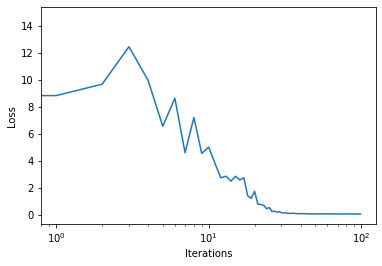

In [14]:
plt.semilogx(loss_hist)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [15]:
k_ops = get_unblock(params, num_kraus)
choi_gd = choi(k_ops)
choi_gd_qutip = Qobj(choi_gd, dims=choi_qutip.dims, superrep="choi")

In [16]:
gd_fidelity =  fidelity(choi_gd_qutip/N, choi_qutip/N)
print(gd_fidelity)

/Users/shahnawaz/miniconda3/envs/gd-qpt/lib/python3.10/site-packages/qutip/qobj.py:530: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


0.9818453614423717


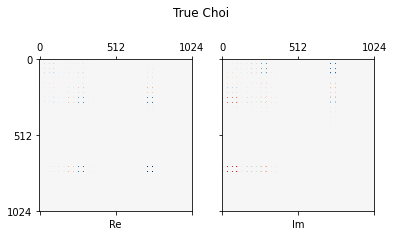

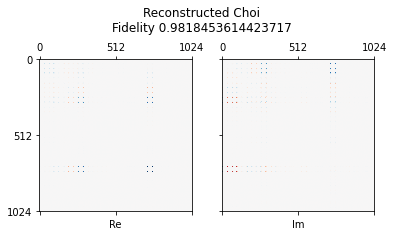

In [17]:
plot_choi(choi_true, title="True Choi")
plt.show()

plot_choi(choi_gd, title=f"Reconstructed Choi\nFidelity {gd_fidelity}")
plt.show()

### Let us now plot the results of the reconstructed data against the noisy data

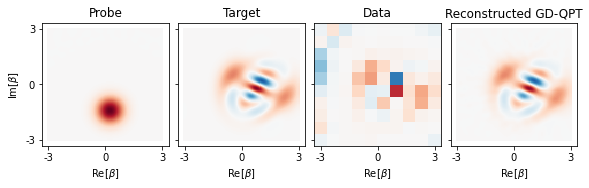

In [18]:
i = 25

fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(8, 2.5), constrained_layout=True)
norm = colors.TwoSlopeNorm(vmin=-2/np.pi, vcenter=0, vmax=2/np.pi)

probe_dm = Qobj(np.array(probes[i]))
true_dm = Qobj(np.array(output_states[i]))

pred_states = apply_process(k_ops, probes)
predicted_dm = Qobj(np.array(pred_states[i]))

xvec = yvec = np.linspace(-beta_max, beta_max, 100)
w_probe = wigner(probe_dm, xvec, yvec, g=2)

# A finer grid to see the full Wigner data
w_full = wigner(true_dm, xvec, yvec, g=2)

# A coarse grid forming our data
w_data = data[i].reshape((len(xvec_betas), len(xvec_betas)))

# Reconstructed data
w_reconstructed = wigner(predicted_dm, xvec, yvec, g=2)

im = ax[0].pcolor(xvec, yvec, w_probe,
                  cmap="RdBu_r", norm=norm)
im = ax[1].pcolor(xvec, yvec,
                  w_full, cmap="RdBu_r", norm=norm)
im = ax[2].pcolor(xvec_betas, yvec_betas,
                  w_data, cmap="RdBu_r", norm=norm)
im = ax[3].pcolor(xvec, yvec,
                  w_reconstructed, cmap="RdBu_r", norm=norm)


ax[0].set_ylabel(r"Im[$\beta$]")
ax[0].set_xlabel(r"Re[$\beta$]")
ax[1].set_xlabel(r"Re[$\beta$]")
ax[2].set_xlabel(r"Re[$\beta$]")
ax[3].set_xlabel(r"Re[$\beta$]")

ax[0].set_xticks([-beta_max, 0, beta_max])
ax[1].set_xticks([-beta_max, 0, beta_max])
ax[0].set_yticks([-beta_max, 0, beta_max])
ax[1].set_yticks([-beta_max, 0, beta_max])

ax[0].set_xticklabels([-beta_max, 0, beta_max])
ax[1].set_xticklabels([-beta_max, 0, beta_max])
ax[0].set_yticklabels([-beta_max, 0, beta_max])
ax[1].set_yticklabels([-beta_max, 0, beta_max])

ax[0].set_title("Probe")
ax[1].set_title("Target")
ax[2].set_title("Data")
ax[3].set_title("Reconstructed GD-QPT")

plt.show()